# Generating DEA Intertidal Elevation

This notebook demonstrates how to generate DEA Intertidal Elevation outputs on
a combination of Landsat and Sentinel-2 data.

**EDIT: modified from the original, here: https://github.com/GeoscienceAustralia/dea-intertidal/blob/rbt/notebooks/Intertidal_elevation_stac.ipynb**

## Getting started

Install additional packages, which may not be in the environment you have ready.

Make sure the kernel you're using is the custom one we made at the start of the workshop.

### Load packages

In [1]:
%load_ext autoreload
%autoreload 2

import os
import xarray as xr
import matplotlib.pyplot as plt
from ipyleaflet import basemaps, basemap_to_tiles

import odc.geo.xr  # noqa: F401
#from odc.ui import select_on_a_map
from dask.distributed import Client as DaskClient

from intertidal.io import prepare_for_export
from intertidal.elevation import elevation
from intertidal.exposure import exposure

from odc.stac import load, configure_s3_access
from pystac_client import Client

import rasterio.features

import geopandas as gpd
import dep_tools.grids as grid

from dea_tools.dask import create_local_dask_cluster

### Configuration

Set up some study parameters. You don't need to change this, but if you want to run over a longer time
period, or iwth a different tide model, you can set that up here.

In [2]:
#os.environ['REQUESTS_CA_BUNDLE'] = ''
#os.environ['PYTHONHTTPSVERIFY'] = '0'
#import ssl
#ssl._create_default_https_context = ssl._create_unverified_context

# Configure study parameters
start_date = "2023"  # Start date for analysis
end_date = "2024"  # End date for analysis
year = "2024"
cloud_cover = 50

# Tide data
tide_model = "FES2022"  # Tide model to use in analysis
#home = os.path.expanduser("~")  # Home directory
tide_model_dir = "tidal_models"  # Directory containing tide model files

### Study site selection

Pick a region to run the model over. There's a section of the Vietnam coast that works well to the east of Nam Dinh.

In [3]:
grid_p = grid.gadm()
country_code = "NRU"
aoi = grid_p[grid_p["GID_0"] == country_code]
aoi = aoi['geometry'].buffer(0.002) #tweak 0.003

#coral_coast
#aoi = gpd.read_file("coral_coast.geojson")

bbox = rasterio.features.bounds(aoi)
#aoi.explore()

/var/folders/vv/hp132l8x00z486_f_xgm161r0000gn/T/ipykernel_27691/2156332222.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  aoi = aoi['geometry'].buffer(0.002) #tweak 0.003


## Find and load data

First we use the Element-84 STAC API to search for Landsat data from the USGS and
then we use the same API to search for Sentinel-2 data from the AWS open data program.

Once we have STAC Items, we load this data and mask clouds out, before calculating
the NDWI index, which is used to compute a wet/dry threshold.

In [4]:
# Configure S3 access. Cloud defaults is an optimisation, while requester pays is required for Landsat
configure_s3_access(cloud_defaults=True, requester_pays=True)

# We're using the Element-84 STAC API, as it provides access to both Landsat and Sentinel-2 records
catalog = "https://earth-search.aws.element84.com/v1"
#datetime = f"{start_date}/{end_date}"
datetime = year
landsat_collection = "landsat-c2-l2"
sentinel2_collection = "sentinel-2-l2a"

# Connect to client
client = Client.open(catalog)

# Search for Landsat items
landsat_items = client.search(
    collections=[landsat_collection],
    bbox=bbox,
    datetime=datetime,
    query={"eo:cloud_cover": {"lt": cloud_cover}},
).item_collection()

# Search for Sentinel-2 items
sentinel2_items = client.search(
    collections=[sentinel2_collection],
    bbox=bbox,
    datetime=datetime,
    query={"eo:cloud_cover": {"lt": cloud_cover}},
).item_collection()

# Check how many items were returned
print(f"Found {len(landsat_items)} Landsat items and {len(sentinel2_items)} Sentinel-2 items")

Found 39 Landsat items and 71 Sentinel-2 items


In [5]:
common_options = {
    "chunks": {"x": 2048, "y": 2048},
    "groupby": "solar_day",
    "resampling": {"qa_pixel": "nearest", "SCL": "nearest", "*": "cubic"},
    "fail_on_error": False,
}

# Load Landsat with ODC STAC
landsat_data = load(
    items=landsat_items,
    bbox=bbox,
    bands=["green", "nir08", "qa_pixel"],
    **common_options,
)

# Apply Landsat cloud mask
# Bit flag mask for the QA_PIXEL band
# We need Bit 3: high confidence cloud, bit 4: high confidence shadow,
# which are the 4th and 5th bits from the right (0-indexed)
bitflags = 0b00011000

cloud_mask = (landsat_data.qa_pixel & bitflags) != 0
landsat_data = landsat_data.where(~cloud_mask).drop_vars("qa_pixel")

sentinel2_data = load(
    items=sentinel2_items,
    like=landsat_data,
    bands=["green", "nir", "scl"],
    **common_options,
)

# Apply Sentinel-2 cloud mask
# 1: defective, 3: shadow, 9: high confidence cloud
mask_flags = [1, 3, 9]

cloud_mask = ~sentinel2_data.scl.isin(mask_flags)
sentinel2_data = sentinel2_data.where(cloud_mask).drop_vars("scl")

# Apply scaling
ds_ls = (landsat_data.where(landsat_data.green != 0) * 0.0000275 + -0.2).clip(0, 1)
ds_s2 = (sentinel2_data.where(sentinel2_data.green != 0) * 0.0001).clip(0, 1)

# Convert to NDWI
ndwi_ls = (ds_ls.green - ds_ls.nir08) / (ds_ls.green + ds_ls.nir08)
ndwi_s2 = (ds_s2.green - ds_s2.nir) / (ds_s2.green + ds_s2.nir)

# Combine into a single dataset
all_data = (
    xr.concat([ndwi_ls, ndwi_s2], dim="time").sortby("time").to_dataset(name="ndwi")
)

all_data

<xarray.Dataset> Size: 18MB
Dimensions:      (y: 209, x: 201, time: 110)
Coordinates:
  * y            (y) float64 2kB -5.529e+04 -5.532e+04 ... -6.15e+04 -6.153e+04
  * x            (x) float64 2kB 7.123e+05 7.123e+05 ... 7.183e+05 7.183e+05
    spatial_ref  int32 4B 32658
  * time         (time) datetime64[ns] 880B 2024-01-01T23:03:45.594285 ... 20...
Data variables:
    ndwi         (time, y, x) float32 18MB dask.array<chunksize=(1, 209, 201), meta=np.ndarray>

## Run the analysis

Up to this point, we've been "lazy loading" our data, using Dask to structure
our data processing plan. The below cells actually load data into memory. and
undertake processing.

First we need to set up a local Dask cluster, and configure S3 access, and then
we can run the model

In [6]:
# Createa a dask Client
#dask_client = DaskClient(
#    n_workers=4, threads_per_worker=16, memory_limit="32GB"
#)
client = create_local_dask_cluster(return_client=True)
# Set cloud access defaults
#configure_s3_access(cloud_defaults=True, aws_unsigned=True)
#odc.stac.configure_rio(cloud_defaults=True, aws={"aws_unsigned": True})


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 12,Total memory: 13.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:61195,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 13.21 GiB
Comm: tcp://127.0.0.1:61200,Total threads: 12
Dashboard: http://127.0.0.1:61201/status,Memory: 13.21 GiB
Nanny: tcp://127.0.0.1:61198,


### Generate Intertidal elevation

In [7]:
# Load all the data for our analysis
loaded = all_data.compute()

/Users/sachin/Projects/dep-projects/.venv/lib/python3.11/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


In [8]:
# Model elevation for each pixel
ds, _ = elevation(
    loaded,
    tide_model=tide_model,
    tide_model_dir=tide_model_dir,
)

2025-02-03 12:38:23 INFO Processing: Modelling tide heights for each pixel


Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2022 in parallel


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.55s/it]


Reprojecting tides into original array


2025-02-03 12:38:38 INFO Processing: Masking nodata and adding tide heights to satellite data array
2025-02-03 12:38:39 INFO Processing: Flattening satellite data array and filtering to intertidal candidate pixels
2025-02-03 12:38:39 INFO Processing: Running per-pixel rolling median


Reducing analysed pixels from 42009 to 5048 (12.02%)


  0%|          | 0/105 [00:00<?, ?it/s]

2025-02-03 12:38:45 INFO Processing: Modelling intertidal elevation
2025-02-03 12:38:45 INFO Processing: Modelling intertidal uncertainty
2025-02-03 12:38:45 INFO Processing: Unflattening data back to its original spatial dimensions
2025-02-03 12:38:45 INFO Processing: Cleaning inaccurate upper intertidal pixels
2025-02-03 12:38:45 INFO Processing: Successfully completed intertidal elevation modelling


Applying tidal interval interpolation to 200 intervals
Applying rolling mean smoothing with radius 20


### Plot outputs

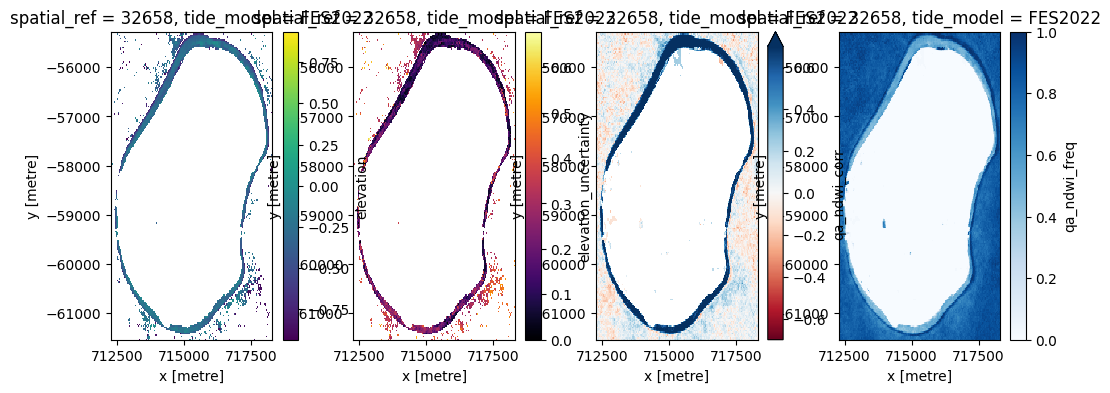

In [9]:
fix, axes = plt.subplots(1, 4, figsize=(12, 4))
ds.elevation.plot.imshow(cmap="viridis", ax=axes[0])
ds.elevation_uncertainty.plot.imshow(cmap="inferno", ax=axes[1])
ds.qa_ndwi_corr.plot.imshow(cmap="RdBu", vmin=-0.7, vmax=0.7, ax=axes[2])
ds.qa_ndwi_freq.plot.imshow(cmap="Blues", vmin=0, vmax=1, ax=axes[3])

In [10]:
#coastal buffer
#buffer = gpd.read_file("../grid/buffered_coastline_grid.gpkg")
#ds = ds.rio.clip(buffer.geometry.values, buffer.crs, drop=False, invert=False)
#aoi buffer
ds = ds.rio.clip(aoi.geometry.values, aoi.crs, drop=False, invert=False)

ds.elevation.odc.explore(
    robust=True,
    tiles=basemaps.Esri.WorldImagery
)

In [11]:
# Exposure variables
modelled_freq = "3h"  # Frequency to run tidal model e.g '30min' or '1h'
filters = None  # Exposure filters eg None, ['Dry', 'Neap_low']
filters_combined = None  # Must be a list of tuples containing one temporal and spatial filter each, eg None or [('Einter','Lowtide')]

exposure_filters, modelledtides_ds = exposure(
    dem=ds.elevation,
    start_date=start_date,
    end_date=end_date,
    modelled_freq=modelled_freq,
    tide_model=tide_model,
    tide_model_dir=tide_model_dir,
    filters=filters,
    filters_combined=filters_combined,
)

# Write each exposure output as new variables in the main dataset
for x in exposure_filters.data_vars:
    ds[f"exposure_{x}"] = exposure_filters[x]

Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2022 in parallel


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.55s/it]


Returning low resolution tide array
Calculating unfiltered exposure


In [12]:
ds

<xarray.Dataset> Size: 2MB
Dimensions:                (y: 209, x: 201)
Coordinates:
  * y                      (y) float64 2kB -5.529e+04 -5.532e+04 ... -6.153e+04
  * x                      (x) float64 2kB 7.123e+05 7.123e+05 ... 7.183e+05
    tide_model             <U7 28B 'FES2022'
    spatial_ref            int64 8B 0
Data variables:
    elevation              (y, x) float64 336kB nan nan nan nan ... nan nan nan
    elevation_uncertainty  (y, x) float64 336kB nan nan nan nan ... nan nan nan
    qa_count_clear         (y, x) int64 336kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    qa_ndwi_corr           (y, x) float64 336kB nan nan nan nan ... nan nan nan
    qa_ndwi_freq           (y, x) float64 336kB nan nan nan nan ... nan nan nan
    exposure_unfiltered    (y, x) float64 336kB nan nan nan nan ... nan nan nan

In [13]:
ds.exposure_unfiltered.odc.explore(
    robust=True,
    tiles=basemaps.Esri.WorldImagery,
    cmap="magma"
)

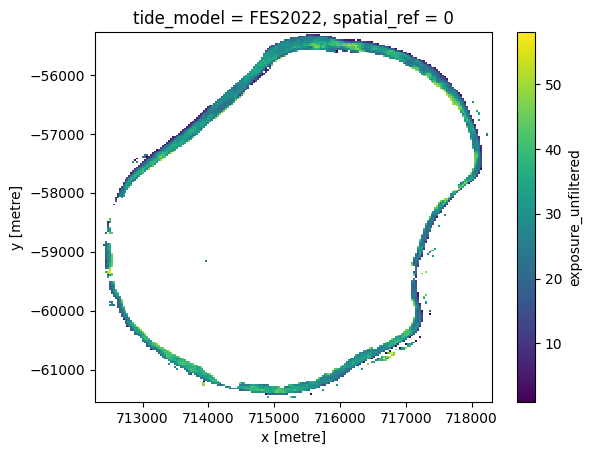

In [14]:
ds.exposure_unfiltered.plot()

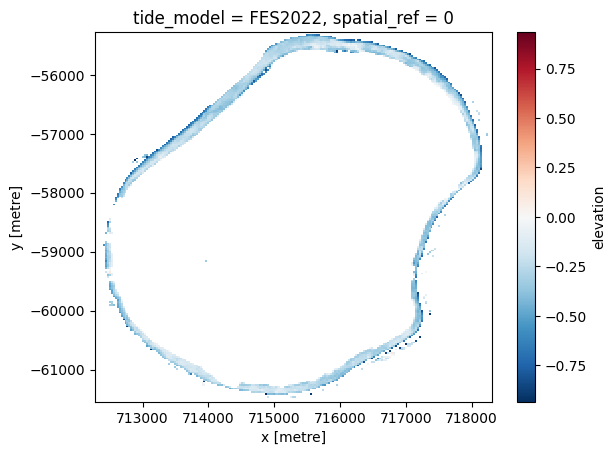

In [15]:
ds.elevation.plot()

### Export to GeoTIFF files

In [16]:
ds = ds.drop_vars("qa_count_clear")
ds = ds.drop_vars("qa_ndwi_corr")
ds = ds.drop_vars("qa_ndwi_freq")
ds = ds.drop_vars("elevation_uncertainty")
ds = ds.rename_vars({"exposure_unfiltered": "exposure"})
ds

<xarray.Dataset> Size: 675kB
Dimensions:      (y: 209, x: 201)
Coordinates:
  * y            (y) float64 2kB -5.529e+04 -5.532e+04 ... -6.15e+04 -6.153e+04
  * x            (x) float64 2kB 7.123e+05 7.123e+05 ... 7.183e+05 7.183e+05
    tide_model   <U7 28B 'FES2022'
    spatial_ref  int64 8B 0
Data variables:
    elevation    (y, x) float64 336kB nan nan nan nan nan ... nan nan nan nan
    exposure     (y, x) float64 336kB nan nan nan nan nan ... nan nan nan nan

In [17]:
# Create output folder if it doesn't exist
#output_dir = f"data/interim/{country_code}/{start_date}-{end_date}"
output_dir = f"data/{country_code}/{year}"
os.makedirs(output_dir, exist_ok=True)

# Prepare data for export
# ds["qa_ndwi_freq"] *= 100  # Convert frequency to %

# Prepare for export by correctly setting nodata and dtypes
ds_prepared = prepare_for_export(ds, output_location=output_dir)

### Close Dask client

In [18]:
client.close()